In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
import numpy as np
import tools  # tools.py, in this directory
from math import tau
from scipy.io import wavfile

pylab.rcParams['figure.figsize'] = 12, 5
𝜏 = tau

Populating the interactive namespace from numpy and matplotlib


In [2]:
hz = 44100
T = 5             # number of seconds
N = hz * T        # number of samples
n = arange(N)     # samples vector
t = n / hz        # time vector, in seconds
start_hz = 20
stop_hz = 10000

# Creating a test signal

In [3]:
# Other waveforms
#a = tools.fuzz(tools.sine_stack(t, 20, 2000, 0.05))
#a = tools.sine_stack(t, 20, 2000, 0.03123)
#print(np.log10(21) - np.log10(20))
resolution = log10(20.57/20)  # 0.5 Hz resolution at 20 Hz
indices, a = tools.sine_stack(t, 20, 8000, resolution)
#a = tools.sine_stack(t, 20, 2000, 0.05)
a = tools.normalize(a)

Creating stacked sine sample 5.0 seconds long
Stacking 214 frequencies:
[  20.    20.6   21.2   21.8   22.4   23.    23.6   24.4   25.    25.8
   26.4   27.2   28.    28.8   29.6   30.4   31.4   32.2   33.2   34.2
   35.    36.    37.2   38.2   39.2   40.4   41.6   42.8   44.    45.2
   46.4   47.8   49.2   50.6   52.    53.4   55.    56.6   58.2   59.8
   61.6   63.4   65.2   67.    68.8   70.8   72.8   75.    77.    79.2
   81.6   83.8   86.2   88.6   91.2   93.8   96.4   99.2  102.   105.
  108.   111.   114.2  117.4  120.8  124.2  127.8  131.4  135.2  139.
  143.   147.   151.2  155.6  160.   164.6  169.2  174.   179.   184.2
  189.4  194.8  200.4  206.   212.   218.   224.2  230.6  237.2  244.
  250.8  258.   265.4  273.   280.6  288.6  297.   305.4  314.   323.
  332.2  341.8  351.4  361.4  371.8  382.4  393.2  404.4  416.   427.8
  440.   452.6  465.4  478.8  492.4  506.4  520.8  535.8  551.   566.6
  582.8  599.4  616.6  634.2  652.2  670.8  689.8  709.6  729.8  750.6
  772.   

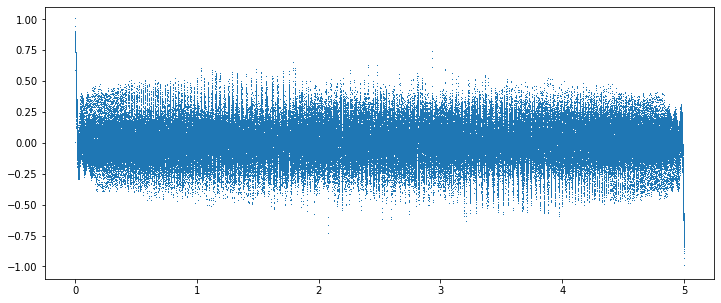

In [4]:
plot(t, a, ',')

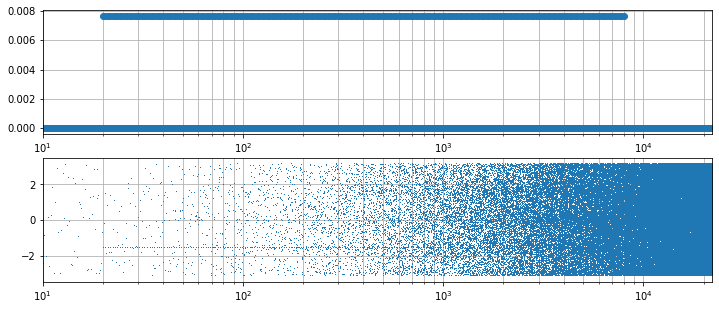

In [5]:
f = fft.fft(a) / N
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(n/T, abs(f), 'o')
ax2.plot(n/T, np.angle(f), ',')
[ax.set_xlim(10, hz/2 - 10) for ax in (ax1, ax2)];
[ax.set_xscale('log') for ax in (ax1, ax2)];
[ax.grid(which='both') for ax in (ax1, ax2)];

In [6]:
left = 32000 * a
right = 0 * a
stereo = np.array([left, right]).astype(np.int16).T
tools.write('sample.wav', hz, left, right)

Saving 5.0 seconds of audio to sample.wav
Maximum excursion: 31999


# Play sample.wav and measure response

Notes:

```
arecord -f cd -c 1 audio-in.wav -D "HDA Intel PCH"

--duration 10
```

In [7]:
# To list:
# "arecord -l" and "aplay -l"
# "arecord -L" and "aplay -L"
#output_device = 'plughw:CARD=PCH,DEV=0'
output_device = 'plughw:CARD=USB,DEV=0'
input_device = 'plughw:CARD=USB,DEV=0'
#input_device = 'usbstream:CARD=USB'

In [8]:
# Quick tests:
#! aplay -D {output_device} sample.wav
#! arecord -f cd -c 2 -D {input_device} --duration=2 audio-in.wav

In [17]:
! (sleep 1; aplay -D {output_device} sample.wav) & arecord -f cd -c 2 -D {input_device} --duration={T+2} audio-in.wav

Recording WAVE 'audio-in.wav' : Signed 16 bit Little Endian, Rate 44100 Hz, Stereo
Playing WAVE 'sample.wav' : Signed 16 bit Little Endian, Rate 44100 Hz, Stereo


-rw-r--r-- 1 brandon brandon 1234844 Feb 20 15:34 audio-in.wav
Choosing left channel


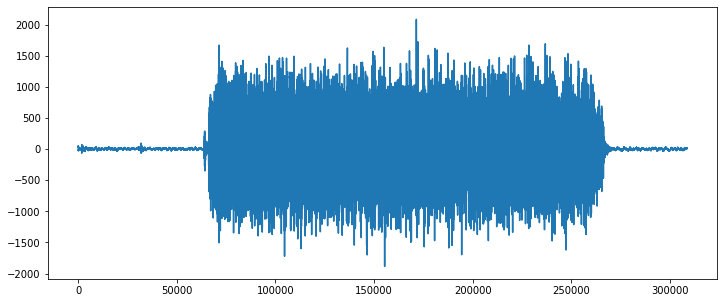

In [10]:
! ls -l audio-in.wav
hz, channels = wavfile.read('audio-in.wav')
left, right = channels.T
if max(abs(left)) > max(abs(right)):
    print('Choosing left channel')
    signal = left
else:
    print('Choosing right channel')
    signal = right
plot(signal)

In [11]:
signal = tools.trim_silence(T, hz, signal)

Keeping 5 of 7 seconds starting at +1.45 seconds


In [12]:
print('Maximum amplitude:', max(abs(signal)))
print('Fraction of available 2^32: {:.3f}'.format(
    max(abs(signal)) / 32768))

Maximum amplitude: 2084
Fraction of available 2^32: 0.064


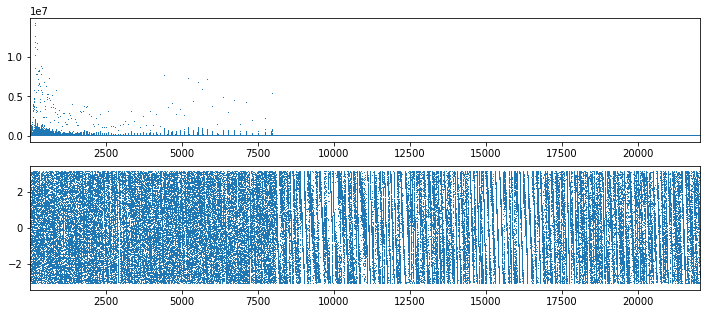

In [13]:
# Overview FFT plot, to see everything that is going on.
N = len(signal)
f = fft.fft(signal)
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(hz * arange(N) / N, abs(f), ',')
ax2.plot(hz * arange(N) / N, np.angle(f), ',')
[ax.set_xlim(10, hz/2 - 10) for ax in (ax1, ax2)];

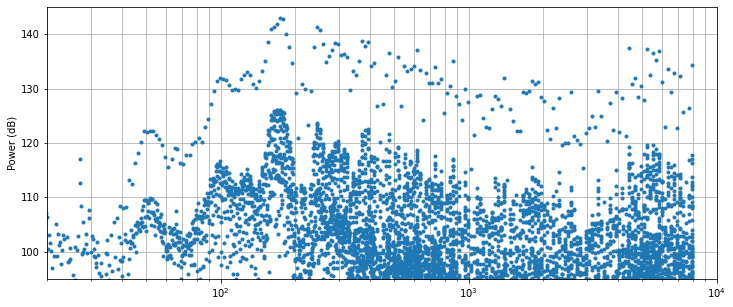

In [14]:
# Plot narrowed to where we expect signal.
N = len(signal)
f = fft.fft(signal)
fig, ax = plt.subplots()
power_dB = 20 * np.log10(abs(f))
ceiling_dB = max(power_dB) // 5 * 5 + 5
ax.plot(hz * arange(N) / N, power_dB, '.')
#ax2.plot(hz * arange(N) / N, np.angle(f), ',')
ax.set_ylabel('Power (dB)')
ax.set_xlim(start_hz, stop_hz)
ax.set_ylim(ceiling_dB - 50.0, ceiling_dB)
#ax.set_ylim(ceiling_dB - 10.0, ceiling_dB)
ax.set_xscale('log')
ax.grid(which='both')

Choosing left channel
Keeping 5 of 7 seconds starting at +1.02 seconds
Choosing left channel
Keeping 5 of 7 seconds starting at +1.45 seconds
Choosing left channel
Keeping 5 of 7 seconds starting at +1.02 seconds
Choosing left channel
Keeping 5 of 7 seconds starting at +1.02 seconds


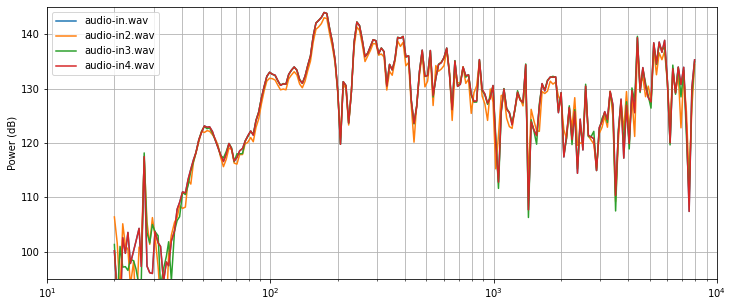

In [23]:
# Plot of our signal frequencies only.

from glob import glob
fig, ax = plt.subplots()

for path in sorted(glob('audio-in*.wav')):
    hz, channels = wavfile.read(path)
    left, right = channels.T
    if max(abs(left)) > max(abs(right)):
        print('Choosing left channel')
        signal = left
    else:
        print('Choosing right channel')
        signal = right
    signal = tools.trim_silence(T, hz, signal)

    N = len(signal)
    frequency = hz * arange(N) / N
    power_dB = 20 * np.log10(abs(fft.fft(signal)))

    frequency = frequency[indices]
    power_dB = power_dB[indices]

    ceiling_dB = max(power_dB) // 5 * 5 + 5
    ax.plot(frequency, power_dB, '-', label=path)

ax.set_ylabel('Power (dB)')
ax.set_xlim(10**int(log10(start_hz)), stop_hz)
ax.set_ylim(ceiling_dB - 50.0, ceiling_dB)
ax.set_xscale('log')
ax.grid(which='both')
ax.legend();

# Appendix: should we trim measured signal?

Yes, trimming the measured signal
to remove the quiet on each end
allows a faster FFT
while returning the exact same curve
but with less noise.

In [ ]:
hz, channels = wavfile.read('audio-in.wav')
left, right = channels.T
plot(right)

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1)

for signal in right, tools.trim_silence(right):
    N = len(signal)
    f = fft.fft(signal)
    ax1.plot(hz * arange(N) / N, abs(f), ',')
    ax2.plot(hz * arange(N) / N, np.angle(f), ',')
    [ax.set_xlim(start_hz, stop_hz) for ax in (ax1, ax2)];
    [ax.set_xscale('log') for ax in (ax1, ax2)];

# Appendix: how far apart should we space sine waves?

In [ ]:
k = arange(0.02, 0.09, 0.001)
factors = []
for ki in k:
    a = tools.sine_stack(t, 20, 2000, ki, False)
    factors.append(max(abs(a)))

In [ ]:
plot(k, factors, '.')

# Bibliography

Pages of possible interest.

https://thanede.wordpress.com/2017/07/03/getting-a-focusrite-scarlett-solo-to-work-under-linux-common-issues/